In [4]:
import sys
sys.path.append('..')

import torch
import os
import torch.nn as nn
import pandas as pd 
import numpy as np
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from LOBnet.Models import TransformerLOB
from LOBnet.Orderbooks import FI2010_Orderbook_Optimized

In [10]:
datapath = "/home/jackklingenberg/Projects/LOBnet/data/BenchmarkDatasets_csv/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training"
window_size = 100
overlap_percent = 0  # 25% overlap between windows
num_workers = 9


In [11]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=datapath,
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers, 
    verbose=True
)

Processing CSV Files:  67%|██████▋   | 6/9 [01:01<00:36, 12.15s/it]

Error processing file /home/jackklingenberg/Projects/LOBnet/data/BenchmarkDatasets_csv/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_8.csv: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing file /home/jackklingenberg/Projects/LOBnet/data/BenchmarkDatasets_csv/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.csv: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing file /home/jackklingenberg/Projects/LOBnet/data/BenchmarkDatasets_csv/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_6.csv: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing file /home/jackklingenberg/Projects/LOBnet/data/Bench

Processing CSV Files: 100%|██████████| 9/9 [01:01<00:00,  6.88s/it]



Raw price movement statistics:
Mean: 1.9846
Std: 0.8952
Min: 1.0000
Max: 3.0000

Label distribution:
0    2230
1    1083
2    2146
Name: count, dtype: int64


In [12]:
# create train/test splits (80/20)
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 5459
Training set size: 4367
Test set size: 1092


In [13]:
# look at first batch
for batch in train_loader:
    batch_X, batch_y = batch  # unpack batch tuple
    print(f"Batch X shape: {batch_X.shape}")  # should be (batch_size, 100, 40)
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([32, 1, 100, 40])
Batch y shape: torch.Size([32, 3])


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training config
batch_size = 128  
learning_rate = 0.001  
num_epochs = 50

# init model and optimizer
model = TransformerLOB(y_len=3, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)
criterion = nn.CrossEntropyLoss()

# save best model to best_transformer.pth
best_val_loss = float('inf')
best_model_path = 'best_transformer.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # training phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch_X, batch_y in train_batches:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        train_batches.set_postfix({'loss': loss.item()})

        _, predicted = torch.max(outputs, dim=1)
        correct_train += (predicted == batch_y.argmax(dim=1)).sum().item()
        total_train += batch_y.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Calculate epoch-level training accuracy
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    val_batches = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

    with torch.no_grad():
        for batch_X, batch_y in val_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            val_batches.set_postfix({'loss': loss.item()})

            _, predicted = torch.max(outputs, dim=1)
            correct_val += (predicted == batch_y.argmax(dim=1)).sum().item()
            total_val += batch_y.size(0)

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # Calculate epoch-level validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # update learning rate
    scheduler.step(avg_val_loss)
    
    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, best_model_path)
        print(f'\nNew best model saved! Validation Loss: {avg_val_loss:.4f}')
    
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')

Epoch 1/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 208.46it/s, loss=1.32] 



New best model saved! Validation Loss: 1.0510

Epoch 1/50:
Average Training Loss: 1.0464
Average Validation Loss: 1.0510


Epoch 2/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 219.74it/s, loss=1.22] 



New best model saved! Validation Loss: 1.0334

Epoch 2/50:
Average Training Loss: 1.0352
Average Validation Loss: 1.0334


Epoch 3/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 226.73it/s, loss=1.21] 



Epoch 3/50:
Average Training Loss: 1.0283
Average Validation Loss: 1.0398


Epoch 4/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 247.12it/s, loss=1.18] 



Epoch 4/50:
Average Training Loss: 1.0254
Average Validation Loss: 1.0414


Epoch 5/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 237.15it/s, loss=1.23] 



New best model saved! Validation Loss: 1.0333

Epoch 5/50:
Average Training Loss: 1.0199
Average Validation Loss: 1.0333


Epoch 6/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 238.24it/s, loss=1.14] 



New best model saved! Validation Loss: 1.0289

Epoch 6/50:
Average Training Loss: 1.0126
Average Validation Loss: 1.0289


Epoch 7/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 220.43it/s, loss=1.09] 



Epoch 7/50:
Average Training Loss: 1.0069
Average Validation Loss: 1.0350


Epoch 8/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 253.77it/s, loss=1.18] 



Epoch 8/50:
Average Training Loss: 1.0024
Average Validation Loss: 1.0433


Epoch 9/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 252.87it/s, loss=1.22] 



Epoch 9/50:
Average Training Loss: 1.0049
Average Validation Loss: 1.0402


Epoch 10/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 223.46it/s, loss=1.14] 



Epoch 10/50:
Average Training Loss: 0.9978
Average Validation Loss: 1.0393


Epoch 11/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 221.03it/s, loss=1.07] 



Epoch 11/50:
Average Training Loss: 0.9863
Average Validation Loss: 1.0418


Epoch 12/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 229.10it/s, loss=1.07] 



Epoch 12/50:
Average Training Loss: 0.9770
Average Validation Loss: 1.0423


Epoch 13/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 220.41it/s, loss=1.09] 



Epoch 13/50:
Average Training Loss: 0.9722
Average Validation Loss: 1.0331


Epoch 14/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 236.81it/s, loss=1.24] 



Epoch 14/50:
Average Training Loss: 0.9657
Average Validation Loss: 1.0526


Epoch 15/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 244.37it/s, loss=1.11] 



Epoch 15/50:
Average Training Loss: 0.9590
Average Validation Loss: 1.0363


Epoch 16/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 240.26it/s, loss=1.21] 



Epoch 16/50:
Average Training Loss: 0.9502
Average Validation Loss: 1.0475


Epoch 17/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 240.54it/s, loss=1.05] 



Epoch 17/50:
Average Training Loss: 0.9471
Average Validation Loss: 1.0306


Epoch 18/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 233.26it/s, loss=1.1]  



Epoch 18/50:
Average Training Loss: 0.9396
Average Validation Loss: 1.0323


Epoch 19/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 254.19it/s, loss=1.11] 



New best model saved! Validation Loss: 1.0252

Epoch 19/50:
Average Training Loss: 0.9273
Average Validation Loss: 1.0252


Epoch 20/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 222.45it/s, loss=1.07] 



New best model saved! Validation Loss: 1.0139

Epoch 20/50:
Average Training Loss: 0.9189
Average Validation Loss: 1.0139


Epoch 21/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 238.66it/s, loss=1.01] 



Epoch 21/50:
Average Training Loss: 0.9187
Average Validation Loss: 1.0187


Epoch 22/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 238.76it/s, loss=1.13] 



Epoch 22/50:
Average Training Loss: 0.9132
Average Validation Loss: 1.0202


Epoch 23/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 249.49it/s, loss=1.12] 



Epoch 23/50:
Average Training Loss: 0.9101
Average Validation Loss: 1.0239


Epoch 24/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 219.71it/s, loss=1.19] 



Epoch 24/50:
Average Training Loss: 0.9075
Average Validation Loss: 1.0193


Epoch 25/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 209.05it/s, loss=1.13] 



Epoch 25/50:
Average Training Loss: 0.9023
Average Validation Loss: 1.0151


Epoch 26/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 217.18it/s, loss=1.13] 



Epoch 26/50:
Average Training Loss: 0.9017
Average Validation Loss: 1.0194


Epoch 27/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 212.29it/s, loss=1.08] 



Epoch 27/50:
Average Training Loss: 0.8972
Average Validation Loss: 1.0145


Epoch 28/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 257.43it/s, loss=1.16] 



Epoch 28/50:
Average Training Loss: 0.8903
Average Validation Loss: 1.0180


Epoch 29/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 240.21it/s, loss=1.11] 



Epoch 29/50:
Average Training Loss: 0.8901
Average Validation Loss: 1.0192


Epoch 30/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 281.77it/s, loss=1.17] 



Epoch 30/50:
Average Training Loss: 0.8940
Average Validation Loss: 1.0188


Epoch 31/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 268.83it/s, loss=1.14] 



Epoch 31/50:
Average Training Loss: 0.8928
Average Validation Loss: 1.0250


Epoch 32/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 254.14it/s, loss=1.18] 



Epoch 32/50:
Average Training Loss: 0.8864
Average Validation Loss: 1.0186


Epoch 33/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 245.81it/s, loss=1.16] 



Epoch 33/50:
Average Training Loss: 0.8904
Average Validation Loss: 1.0205


Epoch 34/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 233.47it/s, loss=1.16] 



Epoch 34/50:
Average Training Loss: 0.8838
Average Validation Loss: 1.0196


Epoch 35/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 255.65it/s, loss=1.19] 



Epoch 35/50:
Average Training Loss: 0.8873
Average Validation Loss: 1.0226


Epoch 36/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 270.57it/s, loss=1.17] 



Epoch 36/50:
Average Training Loss: 0.8893
Average Validation Loss: 1.0174


Epoch 37/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 269.27it/s, loss=1.18] 



Epoch 37/50:
Average Training Loss: 0.8846
Average Validation Loss: 1.0186


Epoch 38/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 188.56it/s, loss=1.16] 



Epoch 38/50:
Average Training Loss: 0.8893
Average Validation Loss: 1.0181


Epoch 39/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 236.63it/s, loss=1.18] 



Epoch 39/50:
Average Training Loss: 0.8863
Average Validation Loss: 1.0165


Epoch 40/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 228.14it/s, loss=1.18] 



Epoch 40/50:
Average Training Loss: 0.8864
Average Validation Loss: 1.0168


Epoch 41/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 284.45it/s, loss=1.19] 



Epoch 41/50:
Average Training Loss: 0.8837
Average Validation Loss: 1.0204


Epoch 42/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 244.93it/s, loss=1.17] 



Epoch 42/50:
Average Training Loss: 0.8852
Average Validation Loss: 1.0212


Epoch 43/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 252.84it/s, loss=1.19] 



Epoch 43/50:
Average Training Loss: 0.8873
Average Validation Loss: 1.0163


Epoch 44/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 247.34it/s, loss=1.17] 



Epoch 44/50:
Average Training Loss: 0.8887
Average Validation Loss: 1.0191


Epoch 45/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 287.51it/s, loss=1.17] 



Epoch 45/50:
Average Training Loss: 0.8847
Average Validation Loss: 1.0175


Epoch 46/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 252.34it/s, loss=1.17] 



Epoch 46/50:
Average Training Loss: 0.8808
Average Validation Loss: 1.0165


Epoch 47/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 261.92it/s, loss=1.14] 



Epoch 47/50:
Average Training Loss: 0.8874
Average Validation Loss: 1.0144


Epoch 48/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 242.70it/s, loss=1.19] 



Epoch 48/50:
Average Training Loss: 0.8823
Average Validation Loss: 1.0171


Epoch 49/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 272.02it/s, loss=1.18] 



Epoch 49/50:
Average Training Loss: 0.8868
Average Validation Loss: 1.0181


Epoch 50/50 [Val]: 100%|██████████| 35/35 [00:00<00:00, 288.81it/s, loss=1.17] 


Epoch 50/50:
Average Training Loss: 0.8819
Average Validation Loss: 1.0163


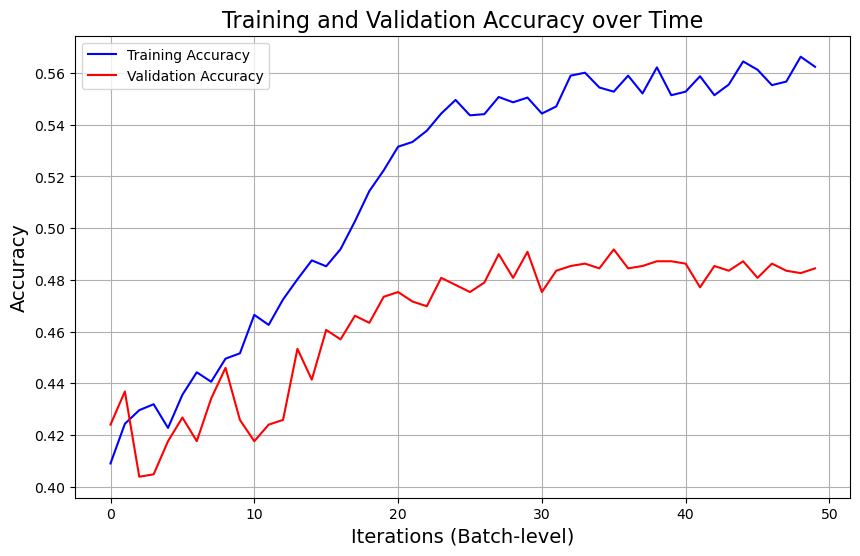

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Iterations (Batch-level)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

Loading saved model from best_transformer.pth


/tmp/ipykernel_189990/3469247164.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Classification Report:
              precision    recall  f1-score   support

 No Movement       0.48      0.48      0.48       433
          Up       0.72      0.23      0.35       220
        Down       0.44      0.60      0.51       439

    accuracy                           0.48      1092
   macro avg       0.55      0.44      0.45      1092
weighted avg       0.51      0.48      0.47      1092



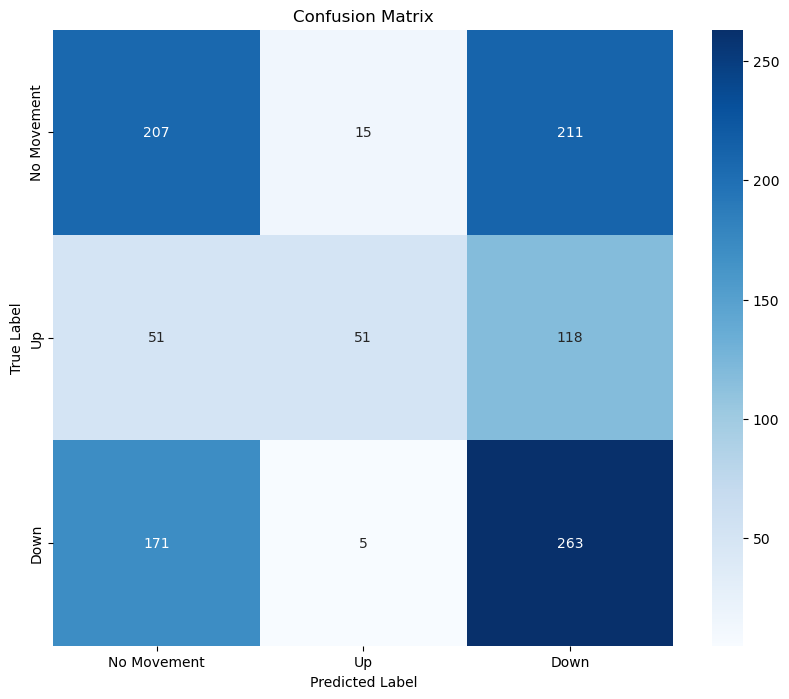

In [16]:
# load the saved model state if it exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'best_transformer.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # set to evaluation mode
else:
    print(f"No saved model found at {model_path}. Please train the model first.")
    exit()

predictions, true_labels = evaluate_model(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['No Movement', 'Up', 'Down']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Movement', 'Up', 'Down'],
            yticklabels=['No Movement', 'Up', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()